In [ ]:
# Add: paired vs. single for chips. PCR for ischip

Populating the interactive namespace from numpy and matplotlib
[0    19.8917
Name: s, dtype: float64, 0    20.607
Name: s, dtype: float64, 0    21.8928
Name: s, dtype: float64, 0    31.6167
Name: s, dtype: float64, 0    44.7609
Name: s, dtype: float64, 0    139.8171
Name: s, dtype: float64, 0    259.1877
Name: s, dtype: float64, 0    1212.9208
Name: s, dtype: float64, 0    2400.0018
Name: s, dtype: float64]
[None, None, None, 0    14.7749
Name: s, dtype: float64, 0    15.2078
Name: s, dtype: float64, 0    15.4285
Name: s, dtype: float64, 0    20.459
Name: s, dtype: float64, 0    26.3494
Name: s, dtype: float64, 0    35.7108
Name: s, dtype: float64]
[0    0.239
Name: s, dtype: float64, 0    0.4904
Name: s, dtype: float64, 0    0.7948
Name: s, dtype: float64, 0    2.1835
Name: s, dtype: float64, 0    4.0089
Name: s, dtype: float64, 0    18.3591
Name: s, dtype: float64, 0    36.6508
Name: s, dtype: float64, 0    179.6567
Name: s, dtype: float64, 0    358.7882
Name: s, dtype: float64]
(0.9

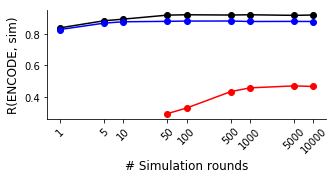

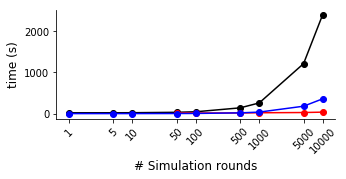

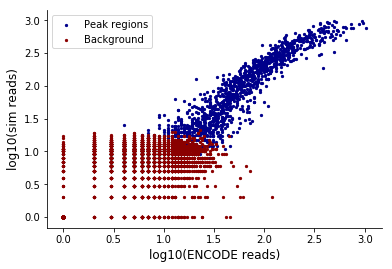

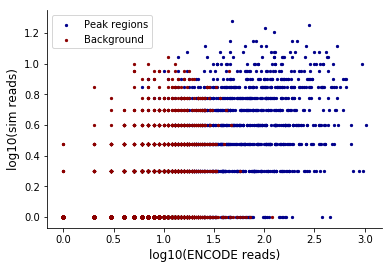

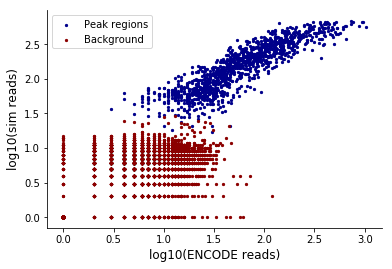

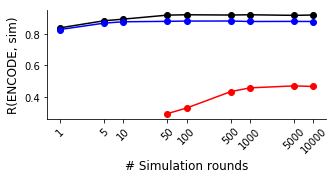

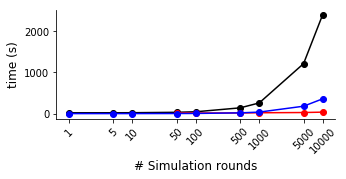

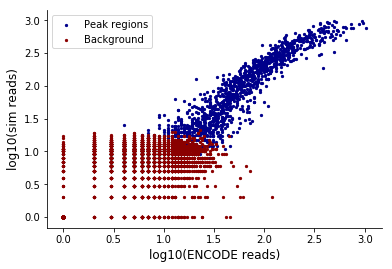

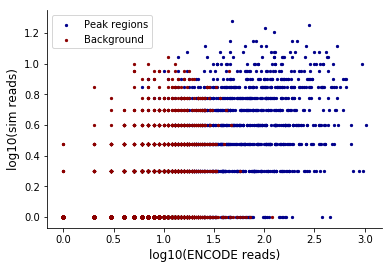

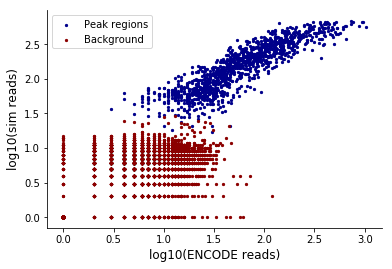

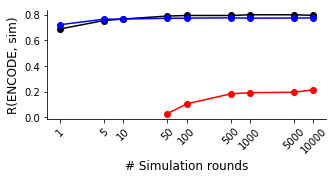

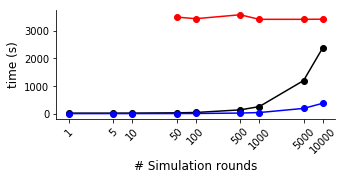

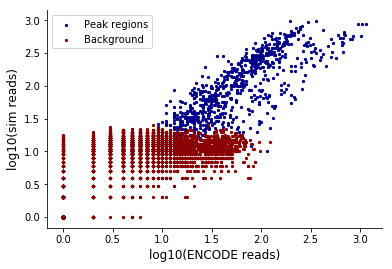

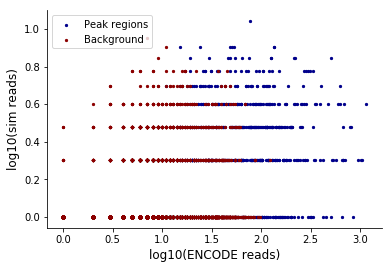

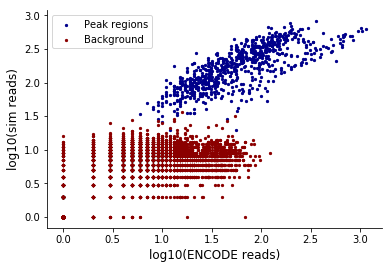

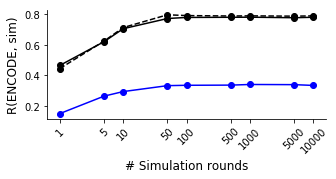

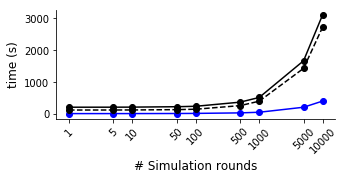

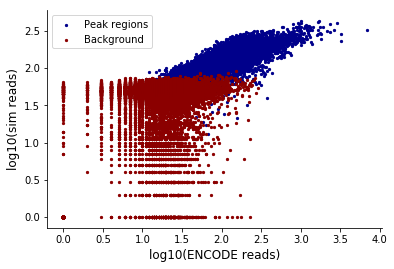

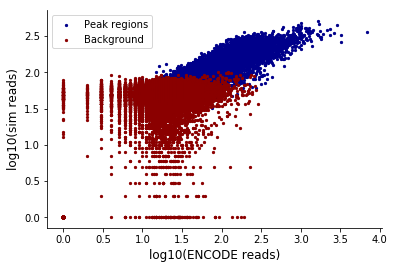

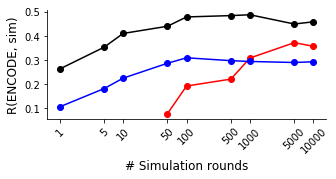

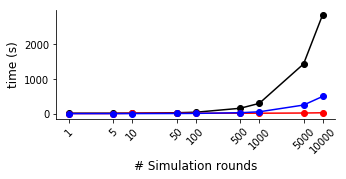

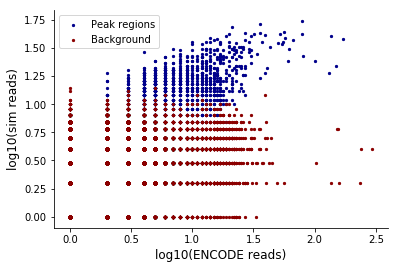

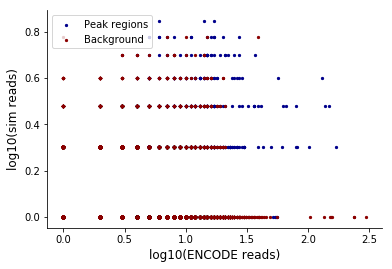

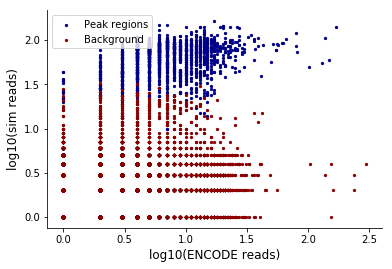

In [6]:
%pylab inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import scipy.stats

SCATTERNUM = 100
METHODS = ["chips","chipulate","ischip"]

NUMCOPIES = np.array([1, 5, 10, 50, 100, 500, 1000, 5000, 10000])

PREFIXES = {"chips": "", "chipulate": "+chipulate", "ischip": "+ischip"}
COLORS = {"chips": "black", "chipulate": "red", "ischip": "blue"}

DATASETS = {
    "H3K27ac-GM": {
        "OUTPREFIX": "GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH",
        "WINDOWSIZE": 5,
        "paired": False
    },
    "H3K4me1-GM": {
        "OUTPREFIX": "GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH",
        "WINDOWSIZE": 5,
        "paired": False
    },
    "H3K4me3-K5": {
        "OUTPREFIX": "K562_H3K4me3_ENCFF681JQI_ENCFF127XXD",
        "WINDOWSIZE": 5,
        "paired": False
    },
    "IZKF1-GM": {
        "OUTPREFIX": "GM12878_IKZF1_ENCFF216YZE_ENCFF795PEX",
        "WINDOWSIZE": 1,
        "paired": True
    },
    "NFYA-K5": {
        "OUTPREFIX": "K562_NFYA_ENCFF000YUR_ENCFF003WYE",
        "WINDOWSIZE": 1,
        "paired": False
    }
}

for ds in DATASETS.keys():
    OUTPREFIX=DATASETS[ds]["OUTPREFIX"]
    WINDOWSIZE=DATASETS[ds]["WINDOWSIZE"]

    # Load Encode data for comparison
    peak = pd.read_csv("windows/%s-%skb.peak.encode.counts"%(OUTPREFIX, WINDOWSIZE),
                             sep="\t",
                             names=["chrom","start","end","encode"])
    nopeak = pd.read_csv("windows/%s-%skb.nopeak.encode.counts"%(OUTPREFIX, WINDOWSIZE),
                             sep="\t",
                             names=["chrom","start","end","encode"])

    # Get numcopies vs. r2, numcopies vs. time. one for each method
    corrs = {}
    times = {}
    for method in METHODS:
        corrs_ = []
        times_ = []
        modifier = PREFIXES[method]
        for nc in NUMCOPIES:
            try:
                dfp = pd.read_csv("windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                dfnp = pd.read_csv("windows/%s-%skb.nopeak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                peak["%s_%s"%(method,nc)] = dfp[nc]
                nopeak["%s_%s"%(method,nc)] = dfnp[nc]
                corrs_.append(scipy.stats.pearsonr(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,nc)]+1))[0])
            except:
                corrs_.append(None)
            try:
                metrics = pd.read_csv("metrics/%s-numcopies%s.sim_metrics"%(OUTPREFIX+modifier, nc), sep="\t")
                times_.append(metrics["s"])
            except:
                times_.append(None)
        corrs[method] = corrs_
        times[method] = times_
    # If paired, add that
    if DATASETS[ds]["paired"]:
        corrs_ = []
        times_ = []
        modifier = "_paired"
        for nc in NUMCOPIES:
            try:
                dfp = pd.read_csv("windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                dfnp = pd.read_csv("windows/%s-%skb.nopeak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                peak["%s_%s"%(method,nc)] = dfp[nc]
                nopeak["%s_%s"%(method,nc)] = dfnp[nc]
                corrs_.append(scipy.stats.pearsonr(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,nc)]+1))[0])
            except:
                corrs_.append(None)
            try:
                metrics = pd.read_csv("metrics/%s-numcopies%s.sim_metrics"%(OUTPREFIX+modifier, nc), sep="\t")
                times_.append(metrics["s"])
            except:
                times_.append(None)
        corrs[method+modifier] = corrs_
        times[method+modifier] = times_        
        
    # Plot numcopies vs. pearson R. One line per method
    fig = plt.figure()
    fig.set_size_inches((5, 2))
    ax = fig.add_subplot(111)
    for method in METHODS:
        ax.plot(np.log10(NUMCOPIES), corrs[method], color=COLORS[method], marker="o")
    if DATASETS[ds]["paired"]:
        ax.plot(np.log10(NUMCOPIES), corrs[method+"_paired"], color=COLORS["chips"], linestyle="dashed", marker="o")
    ax.set_xticks(np.log10(NUMCOPIES))
    ax.set_xticklabels(NUMCOPIES, rotation=45)
    ax.set_xlabel("# Simulation rounds", size=12)
    ax.set_ylabel("R(ENCODE, sim)", size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    fig.savefig(OUTPREFIX+modifier+"-numcopies.pdf")

    # Numcopies vs. time
    fig = plt.figure()
    fig.set_size_inches((5, 2))
    ax = fig.add_subplot(111)
    for method in METHODS:
        print(list(times[method]))
        ax.plot(np.log10(NUMCOPIES), times[method], COLORS[method], marker="o")
    if DATASETS[ds]["paired"]:
        ax.plot(np.log10(NUMCOPIES), times[method+"_paired"], color=COLORS["chips"], linestyle="dashed", marker="o")
    ax.set_xticks(np.log10(NUMCOPIES))
    ax.set_xticklabels(NUMCOPIES, rotation=45)
    ax.set_xlabel("# Simulation rounds", size=12)
    ax.set_ylabel("time (s)", size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    fig.savefig(OUTPREFIX+modifier+"-time.pdf")


    # Get scatter plot of counts
    for method in METHODS:
        if "%s_%s"%(method,SCATTERNUM) not in peak.columns: continue
        modifier = PREFIXES[method]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,SCATTERNUM)]+1), color="darkblue", s=5, label="Peak regions")
        ax.scatter(np.log10(nopeak["encode"]+1), np.log10(nopeak["%s_%s"%(method,SCATTERNUM)]+1), color="darkred", s=5, label="Background")
        print(scipy.stats.pearsonr(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,SCATTERNUM)]+1)))
        print(peak["%s_%s"%(method,SCATTERNUM)].shape)
        #ax.set_xlim(left=-0.1, right=xmax)
        #ax.set_ylim(bottom=-0.1, top=ymax)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel("log10(ENCODE reads)", size=12)
        ax.set_ylabel("log10(sim reads)", size=12);
        ax.legend(loc="upper left");
        fig.savefig(OUTPREFIX+modifier+"-scatter.pdf")